In [18]:
! pip install plotnine
! pip install kmodes
! pip install umap-learn
! pip install networkx
! pip install community
! pip install scikit-learn-extra

In [19]:
from sklearn.metrics import silhouette_score, adjusted_mutual_info_score, adjusted_rand_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import DistanceMetric
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn import preprocessing


from kmodes.kprototypes import KPrototypes
from kmodes.kmodes import KModes
from sklearn_extra.cluster import KMedoids

import umap

import io
import math
import pandas as pd
import numpy as np

from community import community_louvain
import networkx as nx

from matplotlib import gridspec
import matplotlib.pyplot as plt
import plotnine as p9

from google.colab import files
from tqdm.notebook import tqdm_notebook


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

uploaded = files.upload()
data = pd.read_csv(io.BytesIO(uploaded['heart.csv']))

data['sex'] = data['sex'].map({1:'male',0:'female'})
data['fbs'] = data['fbs'].map({1:'true',0:'false'})
data['exang'] = data['exang'].map({1:'true',0:'false'})

data.dropna(inplace=True)

# create target variable
labels = data.pop('target').apply(str)

num_clusters = 2
random_state = 32

data.head()

Saving heart.csv to heart (1).csv


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,male,3,145,233,true,0,150,false,2.3,0,0,1
1,37,male,2,130,250,false,1,187,false,3.5,0,0,2
2,41,female,1,130,204,false,0,172,false,1.4,2,0,2
3,56,male,1,120,236,false,1,178,false,0.8,2,0,2
4,57,female,0,120,354,false,1,163,true,0.6,2,0,2


# Evaluation Metrics

1. Adjusted Rand Index
2. Davies-Bouldin Index
3. Mutual Information
4. Calinski-Harabasz Index
5. Silhouette Score


https://towardsdatascience.com/performance-metrics-in-machine-learning-part-3-clustering-d69550662dc6

In [20]:
def evaluate_clusters(scores,  preds, labels, name='', X=None):

  if X is not None:

    silhouette = silhouette_score(X, preds, metric='euclidean')
    cal_har = calinski_harabasz_score(X, preds)
    dav_bould = davies_bouldin_score(X, preds)

    adj_mut_info = adjusted_mutual_info_score(labels, preds, average_method='arithmetic')
    adj_rand = adjusted_rand_score(labels, preds)

    content = {'Algorithm':name,
               'Silhouette':silhouette,
               'Calinski_Harabasz':cal_har,
               'Davis Bouldin':dav_bould,
               'Adjusted_Mutual_Info':adj_mut_info,
               'Adjusted_Rand_Score':adj_rand}

    scores = scores.append(content, ignore_index = True)

  else:

    adj_mut_info = adjusted_mutual_info_score(labels, preds, average_method='arithmetic')
    adj_rand = adjusted_rand_score(labels, preds)

    content = {'Algorithm':name,
               'Silhouette':np.NaN,
               'Calinski_Harabasz':np.NaN,
               'Davis Bouldin':np.NaN,
               'Adjusted_Mutual_Info':adj_mut_info,
               'Adjusted_Rand_Score':adj_rand}

    scores = scores.append(content, ignore_index = True)


  return scores


scores = pd.DataFrame()
predictions = pd.DataFrame()
predictions['Label'] = labels

# Gower Distance

This is important because if we use GS or GD, we are using a distance that is not obeying the Euclidean geometry. Thus, methods based on Euclidean distance must not be used, as some clustering methods:

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


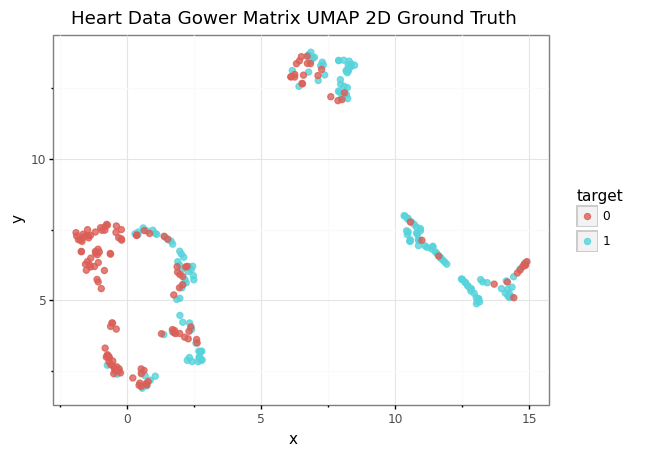

<ggplot: (8792605050773)>

In [21]:
def calculate_gower_distance(df):
  
  '''
  Takes a dataframe as an input and returns the gower distance
  matrix.
  
  '''

  variable_distances = []
  
  for col in range(df.shape[1]):
    
    feature = df.iloc[:,[col]]
    if feature.dtypes.values == np.object:
      
      feature_dist = DistanceMetric.get_metric('dice').pairwise(pd.get_dummies(feature, drop_first=True))
        
    else:
      
      feature_dist = DistanceMetric.get_metric('manhattan').pairwise(feature) / max(np.ptp(feature.values),1)


      variable_distances.append(feature_dist)
      

  return np.array(variable_distances).mean(0)



gower_data = data.copy()
gower_distance_matrix = calculate_gower_distance(gower_data)

umap_embeddings = umap.UMAP(random_state=42, n_components=2).fit_transform(gower_distance_matrix)

gower_data['x'] = umap_embeddings[:,0]
gower_data['y'] = umap_embeddings[:,1]

gower_data['target'] = labels


gower_clusterer = KMedoids(n_clusters=num_clusters, metric='precomputed',
                           method='pam', init='build', 
                           max_iter=300, random_state=random_state).fit(gower_distance_matrix)


gower_data["preds"] = gower_clusterer.labels_
gower_data["preds"] = gower_data["preds"].apply(str)

predictions['gower_preds'] = gower_clusterer.labels_


scores = evaluate_clusters(scores,  gower_data["preds"].values,
                           gower_data['target'].values, 
                           name='gower_matrix_kmediods_pam', 
                           X=gower_distance_matrix)

#--------------------------------------------------------------
#-------------------------plots--------------------------------
#--------------------------------------------------------------

p1 = (p9.ggplot(gower_data, p9.aes(x='x', y='y', fill='target', color='target'))
      + p9.geom_point(alpha=0.8, size=2)
      + p9.ggtitle('Heart Data Gower Matrix UMAP 2D Ground Truth')
      + p9.theme_bw())

p2 = (p9.ggplot(gower_data, p9.aes(x='x', y='y', fill='preds', color='preds'))
      + p9.geom_point(alpha=0.8, size=2)
      + p9.ggtitle('Heart Data Gower Matrix UMAP 2D KMedoids')
      + p9.theme_bw())

p1

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


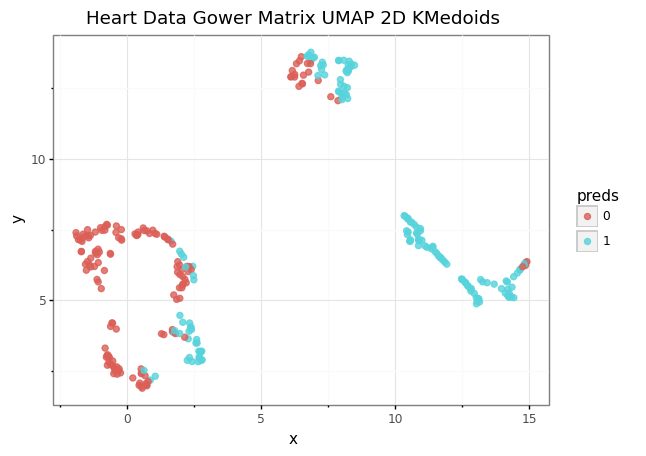

<ggplot: (8792605050533)>

In [22]:
p2

#FAMD

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


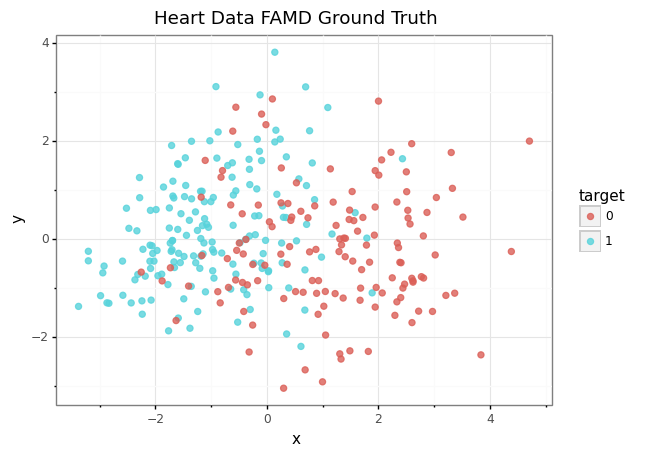

<ggplot: (8792591771733)>

In [23]:
def calculate_zscore(df, columns):
  '''
  scales columns in dataframe using z-score
  '''
  df = df.copy()
  for col in columns:
      df[col] = (df[col] - df[col].mean())/df[col].std(ddof=0)

  return df



def one_hot_encode(df, columns):
  '''
  one hot encodes list of columns and
  concatenates them to the original df
  '''

  concat_df = pd.concat([pd.get_dummies(df[col], drop_first=True, prefix=col) for col in columns], axis=1)
  one_hot_cols = concat_df.columns

  return concat_df, one_hot_cols



def normalize_column_modality(df, columns):
  '''
  divides each column by the probability μₘ of the modality 
  (number of ones in the column divided by N) only for one hot columns
  '''

  length = len(df)
  for col in columns:
    
    weight = math.sqrt(sum(df[col])/length)
    df[col] = df[col]/weight

  return df



def center_columns(df, columns):
  '''
  center columns by subtracting the mean value
  '''
  for col in columns:
      df[col] = (df[col] - df[col].mean())

  return df



def FAMD_(df, n_components=2):
  '''
  Factorial Analysis of Mixed Data (FAMD), 
  which generalizes the Principal Component Analysis (PCA) 
  algorithm to datasets containing numerical and categorical variables

  a) For the numerical variables
    - Standard scale (= get the z-score)
  
  b) For the categorical variables:
    - Get the one-hot encoded columns
    - Divide each column by the square root of its probability sqrt(μₘ)
    - Center the columns

  c) Apply a PCA algorithm over the table obtained!

  '''
  
  variable_distances = []

  numeric_cols = data.select_dtypes(include=np.number)
  cat_cols = data.select_dtypes(include='object')
  
  # numeric process
  normalized_df = calculate_zscore(df, numeric_cols)
  normalized_df = normalized_df[numeric_cols.columns]

  # categorical process
  cat_one_hot_df, one_hot_cols = one_hot_encode(df, cat_cols)
  cat_one_hot_norm_df = normalize_column_modality(cat_one_hot_df, one_hot_cols)
  cat_one_hot_norm_center_df = center_columns(cat_one_hot_norm_df, one_hot_cols)

  # Merge DataFrames
  processed_df = pd.concat([normalized_df, cat_one_hot_norm_center_df], axis=1)

  # Perform (PCA)
  pca = PCA(n_components=n_components)
  principalComponents = pca.fit_transform(processed_df)

  return principalComponents



FAMD_data = data.copy()
FAMD_components = FAMD_(FAMD_data)

FAMD_data['x'] = FAMD_components[:,0]
FAMD_data['y'] = FAMD_components[:,1]

FAMD_data['target'] = labels


FAMD_clusterer = KMeans(n_clusters=num_clusters, init='k-means++',
                        verbose=0, random_state=random_state,
                        algorithm='auto').fit(FAMD_components)


FAMD_data["preds"] = FAMD_clusterer.labels_
FAMD_data["preds"] = FAMD_data["preds"].apply(str)

predictions['FAMD_preds'] = FAMD_clusterer.labels_

scores = evaluate_clusters(scores,  FAMD_data["preds"].values,
                           FAMD_data['target'].values, name='FAMD_Kmeans', 
                           X=FAMD_components)


#--------------------------------------------------------------
#-------------------------plots--------------------------------
#--------------------------------------------------------------

p1 = (p9.ggplot(FAMD_data, p9.aes(x='x', y='y', fill='target', color='target'))
      + p9.geom_point(alpha=0.8, size=2)
      + p9.ggtitle('Heart Data FAMD Ground Truth')
      + p9.theme_bw())

p2 = (p9.ggplot(FAMD_data, p9.aes(x='x', y='y', fill='preds', color='preds'))
      + p9.geom_point(alpha=0.8, size=2)
      + p9.ggtitle('Heart Data FAMD Kmeans')
      + p9.theme_bw())

p1

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


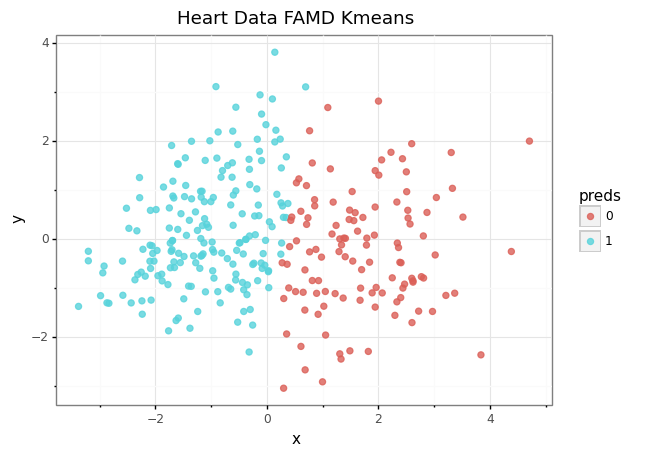

<ggplot: (8792591760101)>

In [24]:
p2

# Dimensionality Reduction with UMAP

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1804: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


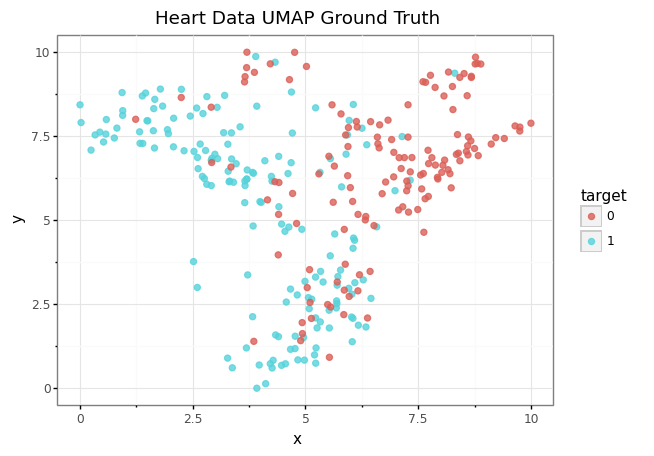

<ggplot: (8792606160509)>

In [25]:
# use Umap to do embedding then cluster on that
def plot_2d_umap(df, intersection=False):

  numerical = df.select_dtypes(exclude='object')

  for c in numerical.columns:
      numerical[c] = (numerical[c] - numerical[c].mean())/numerical[c].std(ddof=0)
      
  ##preprocessing categorical
  categorical = df.select_dtypes(include='object')
  categorical = pd.get_dummies(categorical)

  #Percentage of columns which are categorical is used as weight parameter in embeddings later
  categorical_weight = len(df.select_dtypes(include='object').columns) / df.shape[1]

  #Embedding numerical & categorical
  fit1 = umap.UMAP(random_state=12).fit(numerical)
  fit2 = umap.UMAP(metric='dice', n_neighbors=250).fit(categorical)

  numeric_embedding = fit1.embedding_
  numeric = pd.DataFrame(
                         {'x': numeric_embedding[:,0],
                         'y':  numeric_embedding[:,1],
                        })
  

  categorical_embedding = fit2.embedding_
  categorical = pd.DataFrame(
                         {'x': categorical_embedding[:,0],
                         'y':  categorical_embedding[:,1],
                        })


  # intersection will resemble the numerical embedding more.
  if intersection:
    embedding = fit1 * fit2

  # union will resemble the categorical embedding more.
  else:
    embedding = fit1 + fit2

  umap_embedding = embedding.embedding_


  results = pd.DataFrame(
                        {'x': umap_embedding[:,0],
                         'y':  umap_embedding[:,1],
                        })
  


  numeric = (p9.ggplot(numeric, p9.aes(x='x', y='y'))
              + p9.geom_point(alpha=0.6)
              + p9.ggtitle('Numeric Embedding'))
  
  categorical = (p9.ggplot(categorical, p9.aes(x='x', y='y'))
              + p9.geom_point(alpha=0.6)
              + p9.ggtitle('Categorical Embedding'))
  
  combined = (p9.ggplot(results, p9.aes(x='x', y='y'))
              + p9.geom_point(alpha=0.6)
              + p9.ggtitle('Combined Embedding'))
  
  return numeric, categorical, combined, umap_embedding



UMAP_2D_data = data.copy()

numeric, categorical, combined, embedding_ =  plot_2d_umap(UMAP_2D_data, intersection=True)

UMAP_2D_data['x'] = embedding_[:,0]
UMAP_2D_data['y'] = embedding_[:,1]

UMAP_2D_data['target'] = labels


UMAP_clusterer = KMeans(n_clusters=num_clusters, init='k-means++',
                        verbose=0, random_state=random_state,
                        algorithm='auto').fit(embedding_)

UMAP_2D_data["preds"] = UMAP_clusterer.labels_
UMAP_2D_data["preds"] = UMAP_2D_data["preds"].apply(str)

predictions['UMAP_2D_preds'] = UMAP_clusterer.labels_

scores = evaluate_clusters(scores,  UMAP_2D_data["preds"].values,
                           UMAP_2D_data['target'].values, name='UMAP_2D_Cat_Kmeans', 
                           X=embedding_)

#--------------------------------------------------------------
#-------------------------plots--------------------------------
#--------------------------------------------------------------

p1 = (p9.ggplot(UMAP_2D_data, p9.aes(x='x', y='y', fill='target', color='target'))
      + p9.geom_point(alpha=0.8, size=2)
      + p9.ggtitle('Heart Data UMAP Ground Truth')
      + p9.theme_bw())

p2 = (p9.ggplot(UMAP_2D_data, p9.aes(x='x', y='y', fill='preds', color='preds'))
      + p9.geom_point(alpha=0.8, size=2)
      + p9.ggtitle('Heart Data UMAP Kmeans')
      + p9.theme_bw())

p1

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


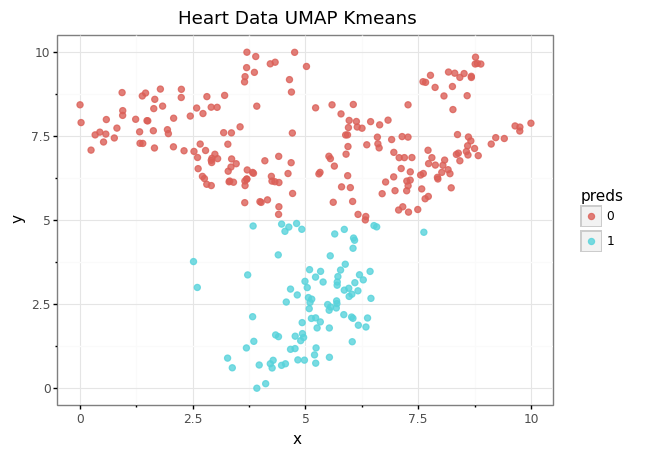

<ggplot: (8792604487369)>

In [26]:
p2

# Recode Categorcial Variables
A general pre-processing and standardization approach for categorical variables is presented in (Mirkin, 2005, pp. 85–91). Categorical variables are first dummy-coded, that is, for each category a separate column is created and observed categories are coded using ones, whereas all other objects are zeros. Then, each dummy variable is standardized by shifting the origin to the mean and dividing it by the standard deviation, the range or another quantity
reflecting the variable’s spread. 

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


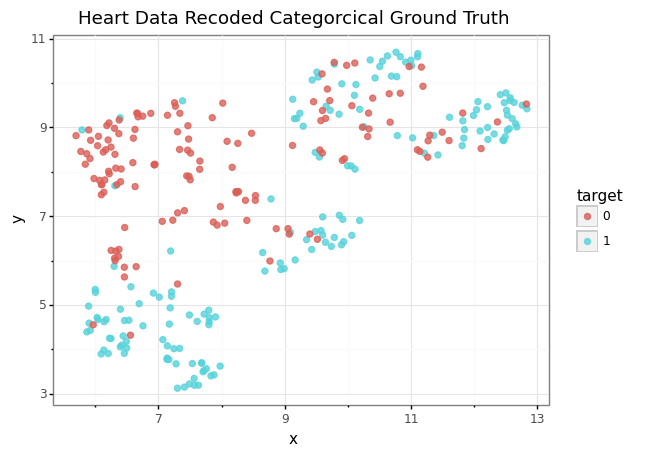

<ggplot: (8792603754781)>

In [27]:
def elbow_method_kmeans(df, space=(2,11)):

  cost = []
  n_clusters = []

  start = space[0]
  stop  = space[1]
  for k in range(start, stop):
      kmeans = KMeans(n_clusters=k, verbose=0)
      kmeans.fit(df)
      cost.append(kmeans.inertia_)
      n_clusters.append(k)


  results = pd.DataFrame(
                        {'n_clusters': n_clusters,
                        'cost': cost,
                        })
  
  
  return (p9.ggplot(results, p9.aes(x='n_clusters', y='cost'))
            + p9.geom_point()
            + p9.geom_line()
            + p9.ggtitle('Elbow Plot'))


continous_data = data.copy()

numeric_cols = continous_data.select_dtypes(include=np.number)
cat_cols = continous_data.select_dtypes(include='object')
  
# numeric process
normalized_df = calculate_zscore(continous_data, numeric_cols)
normalized_df = normalized_df[numeric_cols.columns]

# categorical process
cat_one_hot_df, one_hot_cols = one_hot_encode(continous_data, cat_cols)
cat_one_hot_norm_df = calculate_zscore(cat_one_hot_df, one_hot_cols)

# Merge DataFrames
processed_df = pd.concat([normalized_df, cat_one_hot_norm_df], axis=1)

reduced_2d = umap.UMAP(random_state=12).fit(processed_df).embedding_

continous_data['x'] = reduced_2d[:,0]
continous_data['y'] = reduced_2d[:,1]

continous_data['target'] = labels


Recoded_clusterer = KMeans(n_clusters=num_clusters, init='k-means++',
                        verbose=0, random_state=random_state,
                        algorithm='auto').fit(processed_df)


continous_data["preds"] = Recoded_clusterer.labels_
continous_data["preds"] = continous_data["preds"].apply(str)

predictions['Recode_Cat_Col_preds'] = Recoded_clusterer.labels_

scores = evaluate_clusters(scores, continous_data["preds"].values,
                           continous_data['target'].values, name='Recoded_Cat_Var_Kmeans', 
                           X=processed_df)
 
#--------------------------------------------------------------
#-------------------------plots--------------------------------
#--------------------------------------------------------------

p1 = (p9.ggplot(continous_data, p9.aes(x='x', y='y', fill='target', color='target'))
      + p9.geom_point(alpha=0.8, size=2)
      + p9.ggtitle('Heart Data Recoded Categorcical Ground Truth')
      + p9.theme_bw())

p2 = (p9.ggplot(continous_data, p9.aes(x='x', y='y', fill='preds', color='preds'))
      + p9.geom_point(alpha=0.8, size=2)
      + p9.ggtitle('Heart Data Recoded Categorcical Kmeans')
      + p9.theme_bw())

p1

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


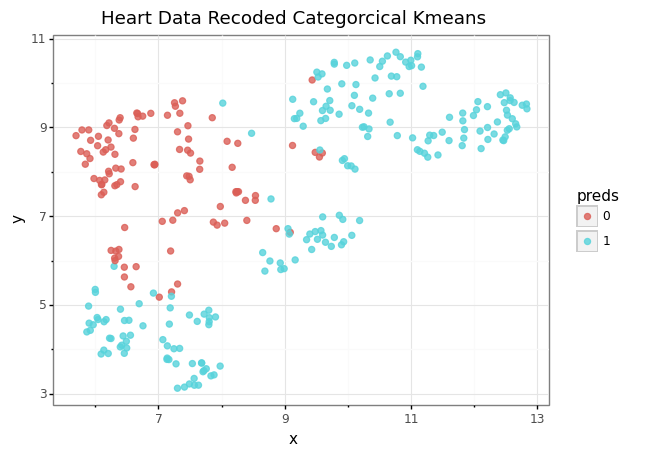

<ggplot: (8792603763449)>

In [28]:
p2

# K-Prototype

K-Prototypes is a lesser known sibling but offers an advantage of workign with mixed data types. It measures distance between numerical features using Euclidean distance (like K-means) but also measure the distance between categorical features using the number of matching categories.

[10, 11, 12]


  0%|          | 0/10 [00:00<?, ?it/s]

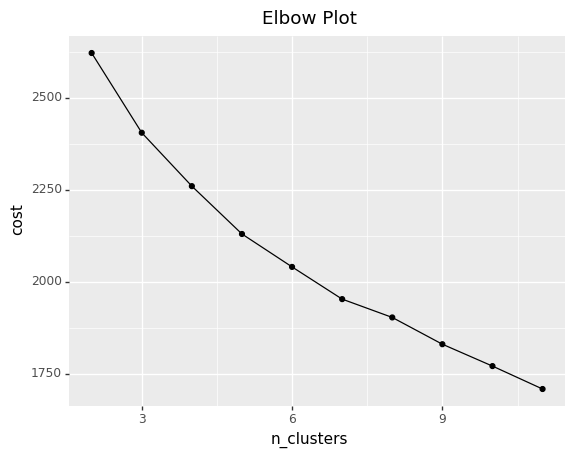

<ggplot: (8792591673961)>

In [29]:
def plot_2d_umap(df):

  numerical = df.select_dtypes(exclude='object')

  for c in numerical.columns:
      numerical[c] = (numerical[col] - numerical[col].mean())/numerical[col].std(ddof=0)
      
  ##preprocessing categorical
  categorical = df.select_dtypes(include='object')
  categorical = pd.get_dummies(categorical)

  #Percentage of columns which are categorical is used as weight parameter in embeddings later
  categorical_weight = len(full_data.select_dtypes(include='object').columns) / full_data.shape[1]

  #Embedding numerical & categorical
  fit1 = umap.UMAP(metric='l2').fit(numerical)
  fit2 = umap.UMAP(metric='dice').fit(categorical)

  #Augmenting the numerical embedding with categorical
  intersection = umap.umap_.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
  intersection = umap.umap_.reset_local_connectivity(intersection)
  embedding = umap.umap_.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                  fit1._initial_alpha, fit1._a, fit1._b, 
                                                  fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                  200, 'random', np.random, fit1.metric, 
                                                  fit1._metric_kwds, False)
  print(embedding)
  plt.figure(figsize=(20, 10))
  plt.scatter(*embedding.T, s=2, cmap='Spectral', alpha=1.0)
  plt.show()



def create_elbow_plot(df, categorical, space=(2,11)):

  costs = []
  n_clusters = []
  clusters_assigned = []
  categorical = list(categorical)
  print(categorical)

  for i in tqdm_notebook(range(space[0], space[1])):

        kproto = KPrototypes(n_clusters= i, init='Cao', verbose=0)
        clusters = kproto.fit_predict(df, categorical=categorical)
        costs.append(kproto.cost_)
        n_clusters.append(i)
        clusters_assigned.append(clusters)



  results = pd.DataFrame(
                        {'n_clusters': n_clusters,
                        'cost': costs,
                        })
  
  
  return (p9.ggplot(results, p9.aes(x='n_clusters', y='cost'))
            + p9.geom_point()
            + p9.geom_line()
            + p9.ggtitle('Elbow Plot'))
  




def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]




k_protype_data = data.copy()

numeric_cols = k_protype_data.select_dtypes(include=np.number)
cat_cols = k_protype_data.select_dtypes(include='object')

norm_num_cols = calculate_zscore(numeric_cols, numeric_cols)
processed_df = pd.concat([norm_num_cols, cat_cols], axis=1)

categorical_indices = column_index(processed_df, cat_cols.columns)
create_elbow_plot(processed_df, categorical_indices, space=(2,12))

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


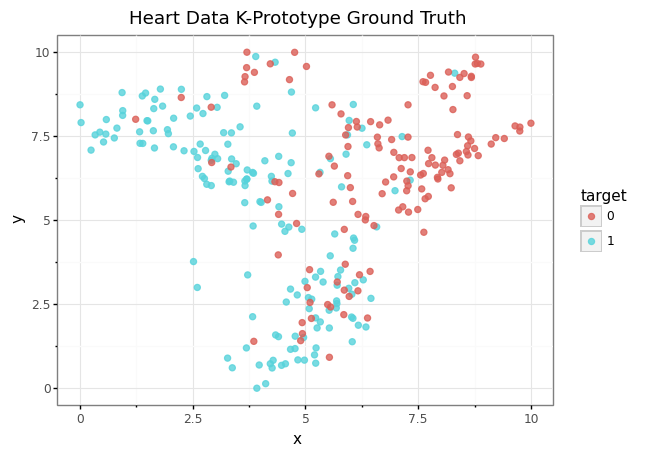

<ggplot: (8792605078781)>

In [30]:
kproto = KPrototypes(n_clusters=num_clusters, init='Cao', 
                     n_jobs = 4, verbose=0, 
                     random_state=random_state)

clusters = kproto.fit_predict(processed_df, categorical=list(categorical_indices))

k_proto_umap = pd.DataFrame({'x':embedding_[:,0],
                             'y':embedding_[:,1],
                             'clusters':clusters,
                             'target':labels
                            })



k_proto_umap['clusters'] = k_proto_umap['clusters'].apply(str)

predictions['K_prototype_preds'] = clusters

scores = evaluate_clusters(scores,  k_proto_umap["clusters"].values,
                           k_proto_umap['target'].values, name='K_Prototype', 
                           X=None)

p1 = (p9.ggplot(k_proto_umap, p9.aes(x='x', y='y', fill='clusters', color='clusters'))
                + p9.geom_point(alpha=0.8, size=2)
                + p9.ggtitle('Heart Data K-Prototype')
                + p9.theme_bw())

p2 = (p9.ggplot(k_proto_umap, p9.aes(x='x', y='y', fill='target', color='target'))
                + p9.geom_point(alpha=0.8, size=2)
                + p9.ggtitle('Heart Data K-Prototype Ground Truth')
                + p9.theme_bw())

p2

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


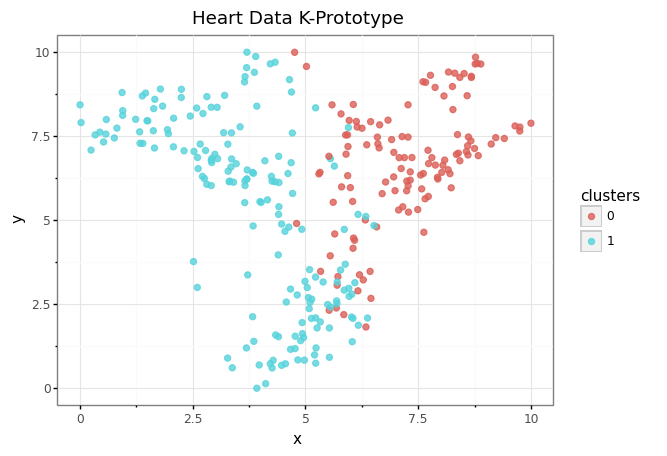

<ggplot: (8792606399993)>

In [31]:
p1

# Recode Continous Variables

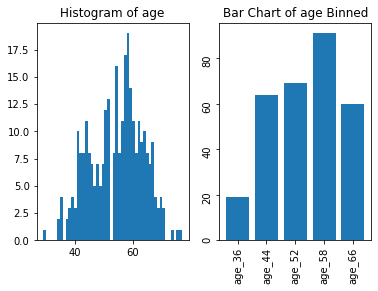

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  """


<Figure size 432x288 with 0 Axes>

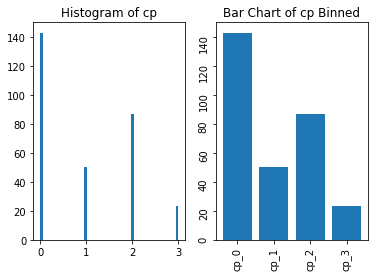

<Figure size 432x288 with 0 Axes>

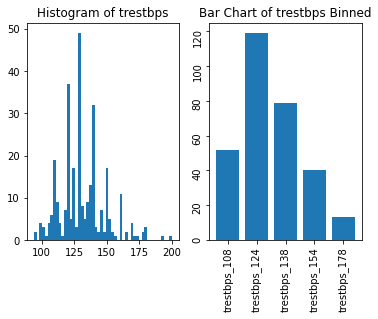

<Figure size 432x288 with 0 Axes>

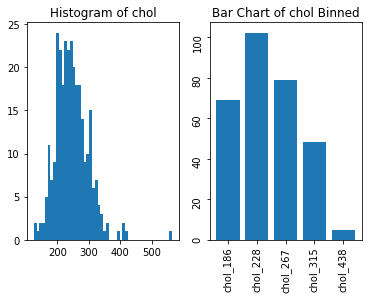

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  """


<Figure size 432x288 with 0 Axes>

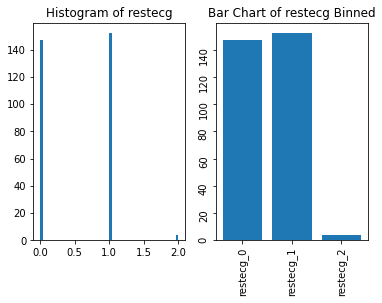

<Figure size 432x288 with 0 Axes>

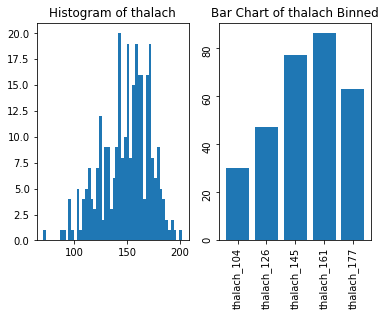

<Figure size 432x288 with 0 Axes>

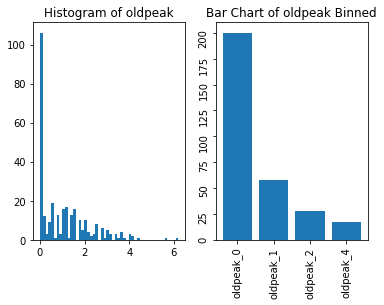

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  """


<Figure size 432x288 with 0 Axes>

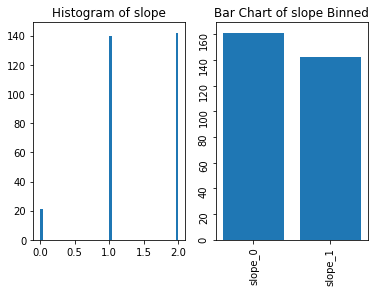

<Figure size 432x288 with 0 Axes>

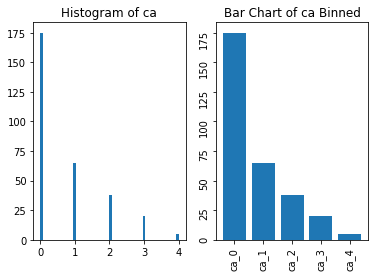

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ConvergenceWarning: Number of distinct clusters (4) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  """


<Figure size 432x288 with 0 Axes>

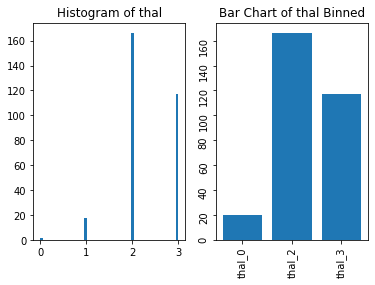

,sex,fbs,exang,age_value,cp_value,trestbps_value,chol_value,restecg_value,thalach_value,oldpeak_value,slope_value,ca_value,thal_value
0,male,true,false,age_66,cp_3,trestbps_138,chol_228,restecg_0,thalach_145,oldpeak_2,slope_0,ca_0,thal_0
1,male,false,false,age_36,cp_2,trestbps_124,chol_267,restecg_1,thalach_177,oldpeak_4,slope_0,ca_0,thal_2
2,female,false,false,age_44,cp_1,trestbps_124,chol_186,restecg_0,thalach_177,oldpeak_1,slope_1,ca_0,thal_2
3,male,false,false,age_58,cp_1,trestbps_124,chol_228,restecg_1,thalach_177,oldpeak_0,slope_1,ca_0,thal_2
4,female,false,true,age_58,cp_0,trestbps_124,chol_315,restecg_1,thalach_161,oldpeak_0,slope_1,ca_0,thal_2


<Figure size 432x288 with 0 Axes>

In [32]:
def get_knn_bins(df, cols, bins=5, drop_cols=True):
  
  for col in cols:
    
    kmeans  = KMeans(n_clusters=bins).fit(df[col].to_frame().values.reshape(-1,1))
    results = pd.DataFrame(kmeans.labels_, columns=[col + '_centroid'])

    df = df.reset_index()
    df[col + '_centroid'] = results[col + '_centroid']
  
    knn_bin_df = pd.DataFrame(kmeans.cluster_centers_)
    knn_bin_df = knn_bin_df.astype(int).reset_index()

    temp_df = pd.merge(df[col + '_centroid'],
                       knn_bin_df, 
                       left_on=col + '_centroid',
                       right_on='index',
                       how='left')
    
    # rename empty column header 0 -> column_name value
    temp_df = temp_df.rename(columns={0:col+'_value'})

    temp_df.loc[:,col+'_value'] = col + '_' + temp_df[col+'_value'].astype(str)

    df = pd.concat([df, temp_df[col+'_value']], axis=1)
    df.drop([col + '_centroid', 'index'], axis=1, inplace=True)


    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    ax1.hist(df[col].values, bins=50)
    ax1.set_title('Histogram of ' + col)

    # produce the second bar chart need the centroids and sort values to make bar chart
    # resemble the original distribution.
    Count_Bins = temp_df[col + '_value'].value_counts().rename_axis('bins').reset_index(name='counts')
    extract_number = Count_Bins.bins.str.extract('([a-zA-Z]+)([^a-zA-Z]+)', expand=True)
    extract_number.columns = ['Text', 'Number']
    Count_Bins['bin_centroid'] = extract_number['Number']
    Count_Bins.sort_values(by=['bin_centroid'], ascending=True, inplace=True)

    ax2.bar(Count_Bins.iloc[:, 0], Count_Bins.iloc[:, 1])
    ax2.set_title('Bar Chart of ' + col + ' Binned')
    ax2.tick_params(labelrotation=90)

    plt.show()
    plt.tight_layout()


  if drop_cols:
    return df.drop(cols, axis=1)

  else:
    return df



recode_df = data.copy()
recoded_df = get_knn_bins(recode_df, numeric_cols, bins=5)
recoded_df.head()

# Kmodes

  0%|          | 0/9 [00:00<?, ?it/s]

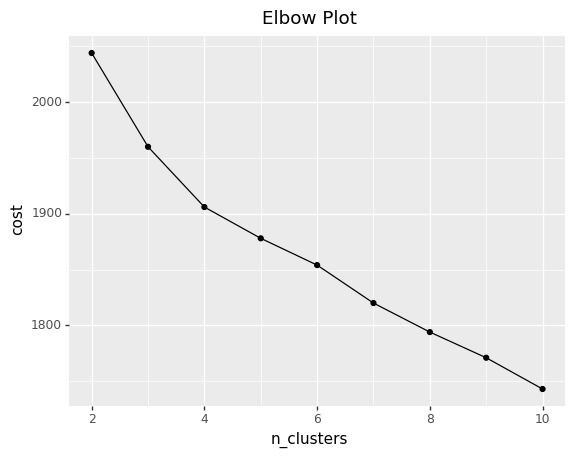

<ggplot: (8792604703085)>

In [33]:
def create_elbow_plot_kmodes(df, space=(2,11)):

  costs = []
  n_clusters = []
  clusters_assigned = []

  cat_cols = df.select_dtypes(include='object')
  categorical_indices = column_index(df, cat_cols.columns)
  categorical = list(categorical_indices)

  for i in tqdm_notebook(range(space[0], space[1])):

        kproto = KModes(n_clusters= i, init='Cao', verbose=0)
        clusters = kproto.fit_predict(df, categorical=categorical)
        costs.append(kproto.cost_)
        n_clusters.append(i)
        clusters_assigned.append(clusters)



  results = pd.DataFrame(
                        {'n_clusters': n_clusters,
                        'cost': costs,
                        })
  
  
  return (p9.ggplot(results, p9.aes(x='n_clusters', y='cost'))
            + p9.geom_point()
            + p9.geom_line()
            + p9.ggtitle('Elbow Plot'))
  


def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]


create_elbow_plot_kmodes(recode_df)

/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1804: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)
/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


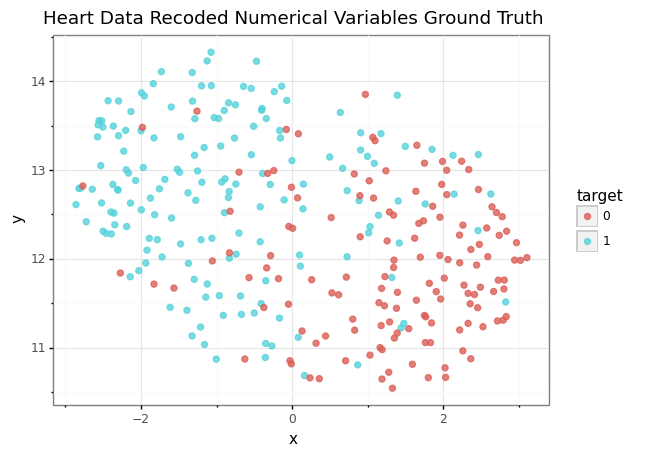

<ggplot: (8792591896133)>

In [34]:
def create_categorical_embedding(df, labels, n_neighbors=150, predictions=None):
  
  cat_cols = df.select_dtypes(include='object')
  df_one_hot, _ = one_hot_encode(df, cat_cols)

  umap_embedding = (umap
                    .UMAP(metric='dice', n_neighbors=n_neighbors)
                    .fit_transform(df_one_hot))
  
  if predictions is None:
  
    results = pd.DataFrame(
                          {'x': umap_embedding[:,0],
                          'y':  umap_embedding[:,1],
                          'target':labels
                          })
    


    return umap_embedding, (p9.ggplot(results, p9.aes(x='x', y='y',fill='preds', 
                                    color='preds'))
                            + p9.geom_point(alpha=0.6)
                            + p9.ggtitle('Recoded Numerical Variables Categorcal Embedding (Labels)'))
    
  else:
    
    results = pd.DataFrame(
                          {'x': umap_embedding[:,0],
                          'y':  umap_embedding[:,1],
                          'preds': predictions,
                          'target':labels
                          })
    
    results['preds'] = results['preds'].astype(str)

    p1 = (p9.ggplot(results, p9.aes(x='x', y='y', 
                                    fill='preds', 
                                    color='preds'))
                            + p9.geom_point(alpha=0.8, size=2)
                            + p9.ggtitle('Heart Data Recoded Numerical Variables Kmodes')
                            + p9.theme_bw())
    
    p2 = (p9.ggplot(results, p9.aes(x='x', y='y', 
                                    fill='target', 
                                    color='target'))
                            + p9.geom_point(alpha=0.8, size=2)
                            + p9.ggtitle('Heart Data Recoded Numerical Variables Ground Truth')
                            + p9.theme_bw())


    return umap_embedding, p1, p2
    

cat_cols = recode_df.select_dtypes(include='object')
categorical_indices = column_index(recode_df, cat_cols.columns)
categorical = list(categorical_indices)

kmodes = KModes(verbose=0,
                n_clusters=num_clusters, 
                random_state=random_state)

kmodes_clusters = kmodes.fit_predict(recode_df, categorical=categorical)
predictions['Kmodes_Recode_Num_Var_preds'] = 1 - kmodes_clusters


scores = evaluate_clusters(scores,  kmodes_clusters,
                           labels, name='Kmodes_Recoded_Continous_Var', X=None)


embedding, p1, p2 = create_categorical_embedding(df=recoded_df, labels=labels, predictions=1 - kmodes_clusters)
p2

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


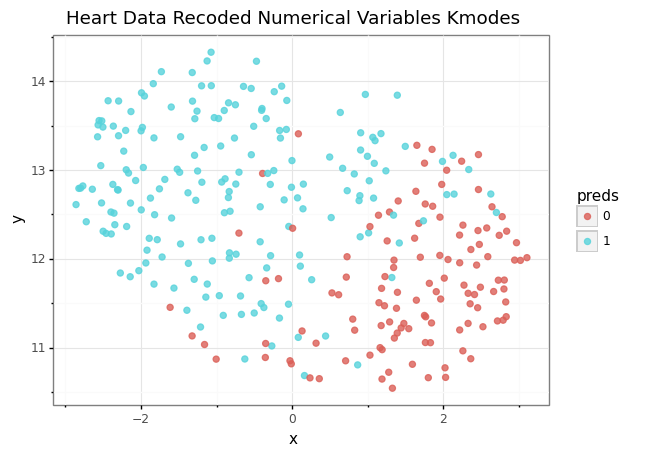

<ggplot: (8792605026165)>

In [35]:
p1

# Categorical Embedding then Clustering

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


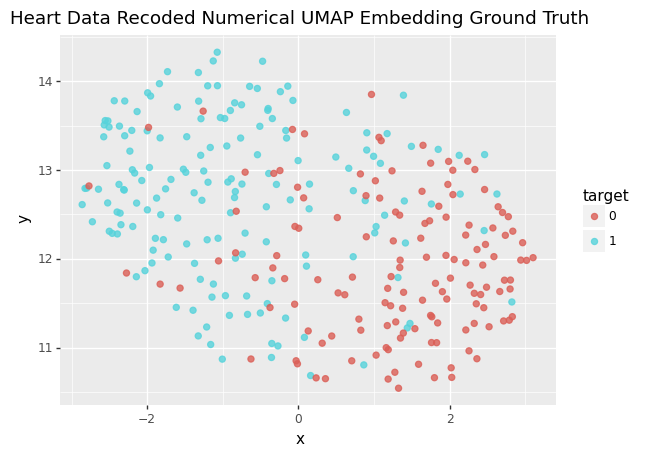

<ggplot: (8792591885633)>

In [36]:
umap_cat_clusterer = KMeans(n_clusters=num_clusters, init='k-means++',
                        verbose=0, random_state=random_state,
                        algorithm='auto').fit(embedding)


results = pd.DataFrame({
                      'x': embedding[:,0],
                      'y': embedding[:,1],
                      'target': labels,
                      'preds': 1 - umap_cat_clusterer.labels_
                      })


results["preds"] = results["preds"].apply(str)

predictions['UMAP_2D_Cat_preds'] = 1 - umap_cat_clusterer.labels_

scores = evaluate_clusters(scores,  results["preds"].values,
                           results['target'].values, name='Umap_2D_Recoded_Continous_Var_Kmeans', 
                           X=embedding)


p1 = (p9.ggplot(results, p9.aes(x='x', y='y', 
                          fill='target', color='target'))
      + p9.geom_point(alpha=0.8, size=2)
      + p9.ggtitle('Heart Data Recoded Numerical UMAP Embedding Ground Truth'))


p2 = (p9.ggplot(results, p9.aes(x='x', y='y', 
                          fill='preds', color='preds'))
      + p9.geom_point(alpha=0.8, size=2)
      + p9.ggtitle('Heart Data Recoded Numerical UMAP Embedding Kmeans'))

p1

/usr/local/lib/python3.7/dist-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


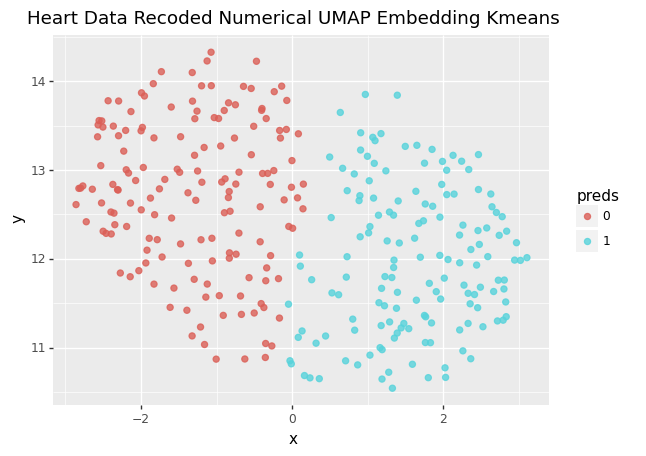

<ggplot: (8792591749529)>

In [37]:
p2

# Using Graph Analytics and Community Detection

In [38]:
def convert_df_to_sgraph_network(df):
  '''
  This function converts a dataframe into an edge list and finally
  into a network graph
  '''
  df = df.copy()
  edges_df = pd.DataFrame()
  # create a name for each row
  length = len(df)
  row_names = ['row '+ str(i) for i in range(1, length+1)]

  original_cols = df.columns
  df['row_name'] = row_names

  for col in original_cols:
    col_edge_df = df[['row_name', col]].rename(columns={col:'to'})
    edges_df = pd.concat([edges_df, col_edge_df], axis=0)

  # set the edge weights to one
  edges_df['weight'] = 1
  edges_df = edges_df.groupby(['row_name', 'to']).count().reset_index()
  edges_df.rename(columns={'row_name':'from'}, inplace=True)


  graph = nx.from_pandas_edgelist(edges_df, source='from',
                                  target='to', edge_attr=['weight'])
  
  return graph


def save_graph_to_gephi(graph, filename=''):
  return nx.write_gexf(graph, filename+".gexf")


graph = convert_df_to_sgraph_network(recoded_df)
save_graph_to_gephi(graph, 'heart')

In [39]:
def convert_community_output_to_df(dict_):
  '''
  this function converts the outut given by the community detection
  algorithm


  list_ = {'row 123':1,'row 234':2,'feature_4':1,'feature_2':2} -> Rows, Cluster
                                                                  'row 123',1
                                                                  'row 234',2

  '''

  rows = []
  clusters = []
  features = []
  feature_clust = []
  for key, value in dict_.items():

    if 'row' in key:
      rows.append(key)
      clusters.append(value)

    else:
      features.append(key)
      feature_clust.append(value)


  return pd.DataFrame({'Rows':rows,
                       'Clusters':clusters}), pd.DataFrame({'Features':features,
                                                            'Clusters':feature_clust})


def merge_clusters_back_df(df, communites):
  
  df = df.copy()
  length = len(df)
  row_names = ['row '+ str(i) for i in range(1, length+1)]

  df['row_name'] = row_names

  df = df.merge(communites, how='left', left_on='row_name', right_on='Rows')

  return df.drop(['row_name', 'Rows'], axis=1, inplace=False)



communities_dict = community_louvain.best_partition(graph)
communites, features = convert_community_output_to_df(communities_dict)
graph_comunities = merge_clusters_back_df(recoded_df, communites)
graph_comunities['target'] = labels

predictions['graph_network_preds'] = graph_comunities["Clusters"].values

graph_comunities.head()

,sex,fbs,exang,age_value,cp_value,trestbps_value,chol_value,restecg_value,thalach_value,oldpeak_value,slope_value,ca_value,thal_value,Clusters,target
0,male,true,false,age_66,cp_3,trestbps_138,chol_228,restecg_0,thalach_145,oldpeak_2,slope_0,ca_0,thal_0,0,1
1,male,false,false,age_36,cp_2,trestbps_124,chol_267,restecg_1,thalach_177,oldpeak_4,slope_0,ca_0,thal_2,1,1
2,female,false,false,age_44,cp_1,trestbps_124,chol_186,restecg_0,thalach_177,oldpeak_1,slope_1,ca_0,thal_2,1,1
3,male,false,false,age_58,cp_1,trestbps_124,chol_228,restecg_1,thalach_177,oldpeak_0,slope_1,ca_0,thal_2,1,1
4,female,false,true,age_58,cp_0,trestbps_124,chol_315,restecg_1,thalach_161,oldpeak_0,slope_1,ca_0,thal_2,1,1


In [40]:
scores = evaluate_clusters(scores,  graph_comunities["Clusters"].values,
                           graph_comunities['target'].values, name='Community_Detection_Graph',
                           X=None)
display(scores)

,Adjusted_Mutual_Info,Adjusted_Rand_Score,Algorithm,Calinski_Harabasz,Davis Bouldin,Silhouette
0,0.275862,0.354718,gower_matrix_kmediods_pam,130.019293,1.465685,0.258971
1,0.276633,0.354563,FAMD_Kmeans,257.154462,0.943161,0.414924
2,0.046785,0.034072,UMAP_2D_Cat_Kmeans,229.586579,0.839758,0.425259
3,0.321725,0.386796,Recoded_Cat_Var_Kmeans,54.965992,2.187384,0.168233
4,0.240027,0.316147,K_Prototype,NaN,NaN,NaN
5,0.282833,0.362529,Kmodes_Recoded_Continous_Var,NaN,NaN,NaN
6,0.295604,0.378847,Umap_2D_Recoded_Continous_Var_Kmeans,498.649072,0.725531,0.512053
7,0.256074,0.361393,Community_Detection_Graph,NaN,NaN,NaN


In [43]:
vf = np.vectorize(adjusted_rand_score, signature='(n),(n)->()')
result = vf(predictions.T.values, predictions.T.values[:, None])
pd.DataFrame(result, index=predictions.columns, columns=predictions.columns)

,Label,gower_preds,FAMD_preds,UMAP_2D_preds,Recode_Cat_Col_preds,K_prototype_preds,Kmodes_Recode_Num_Var_preds,UMAP_2D_Cat_preds,graph_network_preds
Label,1.000000,0.354718,0.354563,0.034072,0.386796,0.316147,0.362529,0.378847,0.361393
gower_preds,0.354718,1.000000,0.483302,-0.002592,0.447184,0.492538,0.549994,0.294204,0.371370
FAMD_preds,0.354563,0.483302,1.000000,0.030443,0.846673,0.859390,0.491359,0.280057,0.385149
UMAP_2D_preds,0.034072,-0.002592,0.030443,1.000000,0.048791,0.020852,-0.007595,0.065271,0.011831
Recode_Cat_Col_preds,0.386796,0.447184,0.846673,0.048791,1.000000,0.717723,0.509241,0.294389,0.343969
K_prototype_preds,0.316147,0.492538,0.859390,0.020852,0.717723,1.000000,0.411434,0.232901,0.412211
Kmodes_Recode_Num_Var_preds,0.362529,0.549994,0.491359,-0.007595,0.509241,0.411434,1.000000,0.412310,0.349431
UMAP_2D_Cat_preds,0.378847,0.294204,0.280057,0.065271,0.294389,0.232901,0.412310,1.000000,0.366424
graph_network_preds,0.361393,0.371370,0.385149,0.011831,0.343969,0.412211,0.349431,0.366424,1.000000
